# 승촌보 데이터 분석

- 승촌보 수질 데이터
    - 2012-2022
    - 시간 단위 수집 데이터
- 승촌보 유량 데이터
    - 2012-2022
    - 10분 단위 수집 데이터

**필수 라이브러리**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

**matplotlib 한글 설정**

- 운영체제에 따른 한글 지원 설정. 윈도우, 우분투, 구글 코랩 지원.
- 참고: [matplotlib에서 한글 지원하기](https://github.com/codingalzi/datapy/blob/master/matplotlib-korean.md)

In [2]:
import platform
plt.rc('figure', figsize=(10, 6))  # 그림 크기 설정
if platform.system() == 'Windows': # 윈도우
    from matplotlib import font_manager, rc
    font_path = "C:/Windows/Fonts/NGULIM.TTF"
    font = font_manager.FontProperties(fname=font_path).get_name()
    rc('font', family=font)
elif platform.system() == 'Linux': # 우분투 또는 구글 코랩
    # !sudo apt-get install -y fonts-nanum*
    # !fc-cache -fv
    
    applyfont = "NanumBarunGothic"
    import matplotlib.font_manager as fm
    if not any(map(lambda ft: ft.name == applyfont, fm.fontManager.ttflist)):
        fm.fontManager.addfont("/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf")
    plt.rc("font", family=applyfont)
    plt.rc("axes", unicode_minus=False)

그레이디언트 부스팅 모델을 활용한다.

In [3]:
# GradientBoosting
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.model_selection import GridSearchCV

표준화 라이브러리도 준비한다.

In [4]:
from sklearn.preprocessing import StandardScaler

## 승촌보 수질 데이터 불러오기

- 2012년부터 2022년까지
- 시간 단위 수집 데이터

**데이터 저장소**

In [5]:
base_path = "https://github.com/codingalzi/water-data/raw/master/reservoirs/"
# base_path = r"C:\Users\owner\Desktop\water-source\data"

승촌보 데이터를 불러온다. 
`'측정일/월'` 특성은 date time으로 파싱한다.

In [6]:
scb_yearly = pd.read_excel(base_path+"Seungchonbo.xlsx", 
# scb_yearly = pd.read_excel(base_path+"\Seungchonbo.xlsx", 
                            skiprows=0, 
                            header=1, 
                            sheet_name=None,
                            na_values='ND',
                            parse_dates=[0])  # 측정일/월 특성을 date time으로 파싱

`scb_yearly`는 연도별 데이터프레임을 갖는 사전 자료형이다.

In [7]:
type(scb_yearly)

dict

년도가 키(key)로 사용된다.

In [8]:
scb_yearly.keys()  # 2012년부터 2022년까지

dict_keys(['2012년', '2013년', '2014년', '2015년', '2016년', '2017년', '2018년', '2019년', '2020년', '2021년', '2022년'])

년도별 특성은 모두 동일하며 다음과 같다.

In [9]:
list(scb_yearly['2012년'].columns)

['측정일/월',
 '측정소명',
 '수온 ℃',
 '수소이온농도',
 '전기전도도 μS/cm',
 '용존산소 mg/L',
 '총유기탄소 mg/L',
 '총질소 mg/L',
 '총인 mg/L',
 '클로로필-a mg/㎥']

예를 들어 2013년 데이터는 다음과 같다.

In [10]:
scb_yearly['2013년']

,측정일/월,측정소명,수온 ℃,수소이온농도,전기전도도 μS/cm,용존산소 mg/L,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥
0,2013-01-01 00:00:00,용봉,3.9,6.9,374.0,11.4,2.5,NaN,NaN,7.2
1,2013-01-01 01:00:00,용봉,3.9,6.9,375.0,11.4,2.5,NaN,NaN,6.9
2,2013-01-01 02:00:00,용봉,4.0,6.9,374.0,11.4,2.5,NaN,NaN,6.8
3,2013-01-01 03:00:00,용봉,4.1,6.9,375.0,11.4,2.5,NaN,NaN,6.9
4,2013-01-01 04:00:00,용봉,4.0,6.9,380.0,11.3,2.6,NaN,NaN,6.9
...,...,...,...,...,...,...,...,...,...,...
8745,2013-12-31 19:00:00,용봉,6.1,6.7,414.0,8.0,3.9,6.523,0.058,10.3
8746,2013-12-31 20:00:00,용봉,6.1,6.7,416.0,7.8,3.8,6.489,0.059,9.9
8747,2013-12-31 21:00:00,용봉,6.1,6.7,416.0,7.9,3.5,6.522,0.058,10.0
8748,2013-12-31 22:00:00,용봉,5.9,6.7,413.0,8.3,3.5,6.600,0.056,11.7


In [11]:
scb_yearly['2013년'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8750 entries, 0 to 8749
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   측정일/월        8750 non-null   datetime64[ns]
 1   측정소명         8750 non-null   object        
 2   수온 ℃         8052 non-null   float64       
 3   수소이온농도       8052 non-null   float64       
 4   전기전도도 μS/cm  8050 non-null   float64       
 5   용존산소 mg/L    7935 non-null   float64       
 6   총유기탄소 mg/L   8042 non-null   float64       
 7   총질소 mg/L     5993 non-null   float64       
 8   총인 mg/L      6048 non-null   float64       
 9   클로로필-a mg/㎥  7109 non-null   float64       
dtypes: datetime64[ns](1), float64(8), object(1)
memory usage: 683.7+ KB


`'측정일/월'` 특성을 '년-월-일 시' 형식으로 변경한다.

In [12]:
for year in list(scb_yearly.keys())[1:]:
    scb_yearly[year]['측정일/월'] = scb_yearly[year]['측정일/월'].apply(lambda x : x.strftime('%Y-%m-%d %H'))

In [13]:
scb_yearly['2013년']

,측정일/월,측정소명,수온 ℃,수소이온농도,전기전도도 μS/cm,용존산소 mg/L,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥
0,2013-01-01 00,용봉,3.9,6.9,374.0,11.4,2.5,NaN,NaN,7.2
1,2013-01-01 01,용봉,3.9,6.9,375.0,11.4,2.5,NaN,NaN,6.9
2,2013-01-01 02,용봉,4.0,6.9,374.0,11.4,2.5,NaN,NaN,6.8
3,2013-01-01 03,용봉,4.1,6.9,375.0,11.4,2.5,NaN,NaN,6.9
4,2013-01-01 04,용봉,4.0,6.9,380.0,11.3,2.6,NaN,NaN,6.9
...,...,...,...,...,...,...,...,...,...,...
8745,2013-12-31 19,용봉,6.1,6.7,414.0,8.0,3.9,6.523,0.058,10.3
8746,2013-12-31 20,용봉,6.1,6.7,416.0,7.8,3.8,6.489,0.059,9.9
8747,2013-12-31 21,용봉,6.1,6.7,416.0,7.9,3.5,6.522,0.058,10.0
8748,2013-12-31 22,용봉,5.9,6.7,413.0,8.3,3.5,6.600,0.056,11.7


**연도별 수질 데이터 통합**

2012년도 데이터를 제외한 모든 데이터를 통합한다.

In [14]:
scb_yearly_df13 = pd.DataFrame()

for year in list(scb_yearly.keys())[1:]:
    scb_yearly_df13 = pd.concat([scb_yearly_df13, scb_yearly[year]])

In [15]:
scb_yearly_df13

,측정일/월,측정소명,수온 ℃,수소이온농도,전기전도도 μS/cm,용존산소 mg/L,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥
0,2013-01-01 00,용봉,3.9,6.9,374.0,11.4,2.5,NaN,NaN,7.2
1,2013-01-01 01,용봉,3.9,6.9,375.0,11.4,2.5,NaN,NaN,6.9
2,2013-01-01 02,용봉,4.0,6.9,374.0,11.4,2.5,NaN,NaN,6.8
3,2013-01-01 03,용봉,4.1,6.9,375.0,11.4,2.5,NaN,NaN,6.9
4,2013-01-01 04,용봉,4.0,6.9,380.0,11.3,2.6,NaN,NaN,6.9
...,...,...,...,...,...,...,...,...,...,...
3427,2022-05-23 19,용봉,26.6,6.9,419.0,NaN,6.7,5.825,0.108,66.2
3428,2022-05-23 20,용봉,26.3,6.8,425.0,NaN,6.5,5.803,0.107,61.2
3429,2022-05-23 21,용봉,25.9,6.8,417.0,NaN,6.7,5.909,0.107,58.3
3430,2022-05-23 22,용봉,25.7,6.8,420.0,NaN,6.4,5.921,0.106,54.4


인덱스를 리셋한다. 기존 인덱스는 제거한다.

In [16]:
scb_yearly_df13 = scb_yearly_df13.reset_index(drop=True)

In [17]:
scb_yearly_df13

,측정일/월,측정소명,수온 ℃,수소이온농도,전기전도도 μS/cm,용존산소 mg/L,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥
0,2013-01-01 00,용봉,3.9,6.9,374.0,11.4,2.5,NaN,NaN,7.2
1,2013-01-01 01,용봉,3.9,6.9,375.0,11.4,2.5,NaN,NaN,6.9
2,2013-01-01 02,용봉,4.0,6.9,374.0,11.4,2.5,NaN,NaN,6.8
3,2013-01-01 03,용봉,4.1,6.9,375.0,11.4,2.5,NaN,NaN,6.9
4,2013-01-01 04,용봉,4.0,6.9,380.0,11.3,2.6,NaN,NaN,6.9
...,...,...,...,...,...,...,...,...,...,...
82252,2022-05-23 19,용봉,26.6,6.9,419.0,NaN,6.7,5.825,0.108,66.2
82253,2022-05-23 20,용봉,26.3,6.8,425.0,NaN,6.5,5.803,0.107,61.2
82254,2022-05-23 21,용봉,25.9,6.8,417.0,NaN,6.7,5.909,0.107,58.3
82255,2022-05-23 22,용봉,25.7,6.8,420.0,NaN,6.4,5.921,0.106,54.4


In [18]:
scb_yearly_df13.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82257 entries, 0 to 82256
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   측정일/월        82257 non-null  object 
 1   측정소명         82257 non-null  object 
 2   수온 ℃         64574 non-null  float64
 3   수소이온농도       64561 non-null  float64
 4   전기전도도 μS/cm  64524 non-null  float64
 5   용존산소 mg/L    62656 non-null  float64
 6   총유기탄소 mg/L   58675 non-null  float64
 7   총질소 mg/L     59981 non-null  float64
 8   총인 mg/L      58997 non-null  float64
 9   클로로필-a mg/㎥  62876 non-null  float64
dtypes: float64(8), object(2)
memory usage: 6.3+ MB


**결측치 확인**

측정일과 측정소를 제외한 모든 특성에 다수의 결측치가 포함된다.

In [19]:
scb_yearly_df13.isnull().sum()

측정일/월              0
측정소명               0
수온 ℃           17683
수소이온농도         17696
전기전도도 μS/cm    17733
용존산소 mg/L      19601
총유기탄소 mg/L     23582
총질소 mg/L       22276
총인 mg/L        23260
클로로필-a mg/㎥    19381
dtype: int64

## 승촌보 유량 데이터 추가

- 2012년부터 2022까지
- 10분 단위 수집 데이터

**승촌보 유량 데이터 불러오기**

`'시간'` 특성은 date time으로 파싱해서 불러온다.

In [20]:
scb_flow_yearly = pd.read_excel(base_path+"Seungchonbo_flow.xlsx", 
# scb_flow_yearly = pd.read_excel(base_path+"\Seungchonbo_flow.xlsx", 
                            header=0, 
                            sheet_name=None,
                            na_values='ND',
                            parse_dates=[0])  # 시간 특성을 date time으로 파싱

`scb_flow_yearly` 또한 연도별 데이터프레임을 갖는 사전이다.

In [21]:
scb_flow_yearly.keys()

dict_keys(['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022'])

예를 들어, 2013년 수량 데이터는 다음과 같다.

In [22]:
scb_flow_yearly["2013"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52560 entries, 0 to 52559
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   시간           52560 non-null  datetime64[ns]
 1    상류수위(EL.m)  52560 non-null  float64       
 2    하류수위(EL.m)  52560 non-null  float64       
 3    유입량(㎥/s)    52560 non-null  float64       
 4    방류량(㎥/s)    52560 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 2.0 MB


In [23]:
scb_flow_yearly["2013"].head(10)

,시간,상류수위(EL.m),하류수위(EL.m),유입량(㎥/s),방류량(㎥/s)
0,2013-01-01 00:00:00,7.5,3.77,19.82,19.74
1,2013-01-01 00:10:00,7.5,3.77,19.78,19.76
2,2013-01-01 00:20:00,7.5,3.77,19.77,19.82
3,2013-01-01 00:30:00,7.5,3.77,19.77,19.73
4,2013-01-01 00:40:00,7.5,3.77,19.78,19.79
5,2013-01-01 00:50:00,7.5,3.77,19.72,19.65
6,2013-01-01 01:00:00,7.5,3.77,19.67,19.58
7,2013-01-01 01:10:00,7.5,3.77,19.61,19.60
8,2013-01-01 01:20:00,7.5,3.77,19.61,19.66
9,2013-01-01 01:30:00,7.5,3.77,19.68,19.77


**시간 단위 데이터로 변환**

10분 단위로 수집된 수량 데이터를 시간 단위 데이터로 변환한다.
단,  데이터가 적은 2012년도 데이터는 무시한다.

- `'시간'` 특성을 '년-월-일 시' 형식으로 변경한다.

In [24]:
for year in list(scb_flow_yearly.keys())[1:]:
    scb_flow_yearly[year]['시간'] = scb_flow_yearly[year]['시간'].apply(lambda x : x.strftime('%Y-%m-%d %H'))

In [25]:
scb_flow_yearly['2013'].head(10)

,시간,상류수위(EL.m),하류수위(EL.m),유입량(㎥/s),방류량(㎥/s)
0,2013-01-01 00,7.5,3.77,19.82,19.74
1,2013-01-01 00,7.5,3.77,19.78,19.76
2,2013-01-01 00,7.5,3.77,19.77,19.82
3,2013-01-01 00,7.5,3.77,19.77,19.73
4,2013-01-01 00,7.5,3.77,19.78,19.79
5,2013-01-01 00,7.5,3.77,19.72,19.65
6,2013-01-01 01,7.5,3.77,19.67,19.58
7,2013-01-01 01,7.5,3.77,19.61,19.60
8,2013-01-01 01,7.5,3.77,19.61,19.66
9,2013-01-01 01,7.5,3.77,19.68,19.77


- 시간대별 평균 수량으로 구성된 데이터셋 구현

In [26]:
scb_flow_yearly_hour = {}

for year in list(scb_flow_yearly.keys())[1:]:
    scb_flow_yearly_hour[year] = scb_flow_yearly[year].groupby('시간').mean()

In [27]:
scb_flow_yearly_hour['2013'].head(10)

,상류수위(EL.m),하류수위(EL.m),유입량(㎥/s),방류량(㎥/s)
시간,,,,
2013-01-01 00,7.500000,3.77,19.773333,19.748333
2013-01-01 01,7.500000,3.77,19.701667,19.706667
2013-01-01 02,7.500000,3.77,19.748333,19.723333
2013-01-01 03,7.500000,3.77,19.613333,19.610000
2013-01-01 04,7.500000,3.77,19.661667,19.665000
2013-01-01 05,7.500000,3.77,19.641667,19.635000
2013-01-01 06,7.500000,3.77,19.573333,19.566667
2013-01-01 07,7.491667,3.77,16.646667,19.496667
2013-01-01 08,7.490000,3.77,19.495000,19.500000


- 인덱스 추가

In [28]:
for year in scb_flow_yearly_hour:
    scb_flow_yearly_hour[year] = scb_flow_yearly_hour[year].reset_index()

In [29]:
scb_flow_yearly_hour['2013'].head(10)

,시간,상류수위(EL.m),하류수위(EL.m),유입량(㎥/s),방류량(㎥/s)
0,2013-01-01 00,7.500000,3.77,19.773333,19.748333
1,2013-01-01 01,7.500000,3.77,19.701667,19.706667
2,2013-01-01 02,7.500000,3.77,19.748333,19.723333
3,2013-01-01 03,7.500000,3.77,19.613333,19.610000
4,2013-01-01 04,7.500000,3.77,19.661667,19.665000
5,2013-01-01 05,7.500000,3.77,19.641667,19.635000
6,2013-01-01 06,7.500000,3.77,19.573333,19.566667
7,2013-01-01 07,7.491667,3.77,16.646667,19.496667
8,2013-01-01 08,7.490000,3.77,19.495000,19.500000
9,2013-01-01 09,7.486667,3.77,17.576667,19.478333


**승촌보 유량 통합 데이터**

2013년 이후의 연도별 데이터를 모두 통합한다. 

In [30]:
scb_flow_yearly_hour_df = pd.DataFrame()

for year in scb_flow_yearly_hour:
    scb_flow_yearly_hour_df = pd.concat([scb_flow_yearly_hour_df, scb_flow_yearly_hour[year]])

In [31]:
scb_flow_yearly_hour_df

,시간,상류수위(EL.m),하류수위(EL.m),유입량(㎥/s),방류량(㎥/s)
0,2013-01-01 00,7.500000,3.770000,19.773333,19.748333
1,2013-01-01 01,7.500000,3.770000,19.701667,19.706667
2,2013-01-01 02,7.500000,3.770000,19.748333,19.723333
3,2013-01-01 03,7.500000,3.770000,19.613333,19.610000
4,2013-01-01 04,7.500000,3.770000,19.661667,19.665000
...,...,...,...,...,...
5487,2022-08-17 15,5.536667,1.618333,29.261667,25.190000
5488,2022-08-17 16,5.525000,1.638333,23.243333,38.923333
5489,2022-08-17 17,5.483333,1.626667,29.068333,44.878333
5490,2022-08-17 18,5.470000,1.566667,19.131667,14.925000


통합 데이터의 인덱스를 새로 구성한다.

In [32]:
scb_flow_yearly_hour_df = scb_flow_yearly_hour_df.reset_index(drop=True)

총 84,354개의 수량 데이터 샘플이 포함된다.

In [33]:
scb_flow_yearly_hour_df

,시간,상류수위(EL.m),하류수위(EL.m),유입량(㎥/s),방류량(㎥/s)
0,2013-01-01 00,7.500000,3.770000,19.773333,19.748333
1,2013-01-01 01,7.500000,3.770000,19.701667,19.706667
2,2013-01-01 02,7.500000,3.770000,19.748333,19.723333
3,2013-01-01 03,7.500000,3.770000,19.613333,19.610000
4,2013-01-01 04,7.500000,3.770000,19.661667,19.665000
...,...,...,...,...,...
84349,2022-08-17 15,5.536667,1.618333,29.261667,25.190000
84350,2022-08-17 16,5.525000,1.638333,23.243333,38.923333
84351,2022-08-17 17,5.483333,1.626667,29.068333,44.878333
84352,2022-08-17 18,5.470000,1.566667,19.131667,14.925000


## 수질/수량 데이터 합병

수질 데이터와 수량 데이터를 `측정일/월`과 `'시간'` 기준으로 합병한다.
이를 위해 수질 데이터의 `측정일/월` 특성 이름을 `'시간'`으로 변경한다.

In [45]:
scb_yearly_df13 = scb_yearly_df13.rename(columns={'측정일/월':'시간'})
scb_yearly_df13

,시간,측정소명,수온 ℃,수소이온농도,전기전도도 μS/cm,용존산소 mg/L,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥
0,2013-01-01 00,용봉,3.9,6.9,374.0,11.4,2.5,NaN,NaN,7.2
1,2013-01-01 01,용봉,3.9,6.9,375.0,11.4,2.5,NaN,NaN,6.9
2,2013-01-01 02,용봉,4.0,6.9,374.0,11.4,2.5,NaN,NaN,6.8
3,2013-01-01 03,용봉,4.1,6.9,375.0,11.4,2.5,NaN,NaN,6.9
4,2013-01-01 04,용봉,4.0,6.9,380.0,11.3,2.6,NaN,NaN,6.9
...,...,...,...,...,...,...,...,...,...,...
82252,2022-05-23 19,용봉,26.6,6.9,419.0,NaN,6.7,5.825,0.108,66.2
82253,2022-05-23 20,용봉,26.3,6.8,425.0,NaN,6.5,5.803,0.107,61.2
82254,2022-05-23 21,용봉,25.9,6.8,417.0,NaN,6.7,5.909,0.107,58.3
82255,2022-05-23 22,용봉,25.7,6.8,420.0,NaN,6.4,5.921,0.106,54.4


이제 `'시간'` 특성 기준으로 합병(merge)가 가능하다.
- `how=outer` 키워드 인자: 두 데이터에 사용된 모든 시간대의 데이터를 모두 추가한다.

In [75]:
scb_data = pd.merge(left=scb_yearly_df13, right=scb_flow_yearly_hour_df, on='시간', how='outer')
scb_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84380 entries, 0 to 84379
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   시간           84380 non-null  object 
 1   측정소명         82257 non-null  object 
 2   수온 ℃         64574 non-null  float64
 3   수소이온농도       64561 non-null  float64
 4   전기전도도 μS/cm  64524 non-null  float64
 5   용존산소 mg/L    62656 non-null  float64
 6   총유기탄소 mg/L   58675 non-null  float64
 7   총질소 mg/L     59981 non-null  float64
 8   총인 mg/L      58997 non-null  float64
 9   클로로필-a mg/㎥  62876 non-null  float64
 10   상류수위(EL.m)  84354 non-null  float64
 11   하류수위(EL.m)  84354 non-null  float64
 12   유입량(㎥/s)    84354 non-null  float64
 13   방류량(㎥/s)    84354 non-null  float64
dtypes: float64(12), object(2)
memory usage: 9.7+ MB


수질 데이터는 총 82,257개의 데이터 샘플이 포함된다.

In [76]:
scb_len = len(scb_yearly_df13)
scb_len


82257

수질 데이터 크기만큼만 합병된 데이터를 다룬다. (<font color='red'>이유는 수량 데이터 뒷쪽이 추가되었기 때문?</font>)

In [77]:
scb_data = scb_data[:scb_len]

특성명을 클리닝한다. (<font color='red'>필요?</font>)

In [78]:
scb_data.columns = [x.strip() for x in list(scb_data.columns)]

**특성 선택**

훈련에 사용할 특성을 선택한다.

In [79]:
scb_features = list(scb_data.columns)
scb_features = scb_features[:3]  + scb_features[4:5] + scb_features[6:-3] + scb_features[-1:]
scb_data = scb_data.loc[:, scb_features]

선택된 특성은 아래와 같다.

In [80]:
scb_data.columns

Index(['시간', '측정소명', '수온 ℃', '전기전도도 μS/cm', '총유기탄소 mg/L', '총질소 mg/L',
       '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)'],
      dtype='object')

**결측치 확인**

- 특성별 결측치 비율

In [81]:
scb_data.isnull().sum() / len(scb_data)

시간             0.000000
측정소명           0.000000
수온 ℃           0.214973
전기전도도 μS/cm    0.215580
총유기탄소 mg/L     0.286687
총질소 mg/L       0.270810
총인 mg/L        0.282772
클로로필-a mg/㎥    0.235615
상류수위(EL.m)     0.000316
방류량(㎥/s)       0.000316
dtype: float64

- 결측치 분포 히트맵: 결측치가 한 동안 없는 경우도 존재

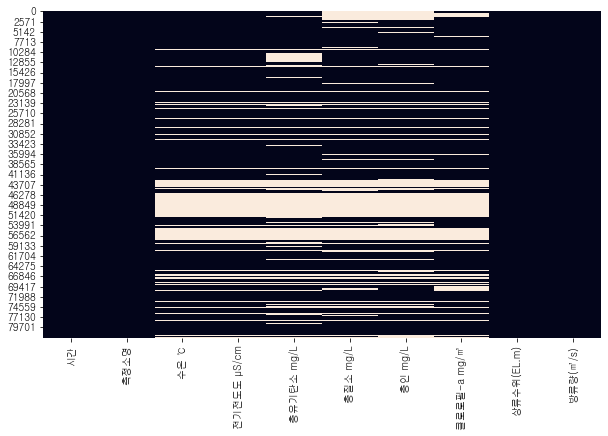

In [63]:
sns.heatmap(scb_data.isnull(), cbar=False)
plt.show()

수치형 특성들 사이의 피어슨 상관관계를 살펴본다. (<font color='red'>왜 필요?</font>)

- `'상류수위'`와 `'방류량'` 을 제외한 나머지 특성들 사이의 상관관계가 매우 큼.

In [84]:
scb_data_numeric = scb_data.iloc[:, 2:]
scb_data_numeric.isnull().corr(method='pearson')

,수온 ℃,전기전도도 μS/cm,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥,상류수위(EL.m),방류량(㎥/s)
수온 ℃,1.000000,0.997627,0.784735,0.771253,0.753176,0.893317,-0.005975,-0.005975
전기전도도 μS/cm,0.997627,1.000000,0.784629,0.770361,0.752133,0.891512,-0.005996,-0.005996
총유기탄소 mg/L,0.784735,0.784629,1.000000,0.698539,0.677277,0.726571,-0.005223,-0.005223
총질소 mg/L,0.771253,0.770361,0.698539,1.000000,0.884298,0.771919,-0.007758,-0.007758
총인 mg/L,0.753176,0.752133,0.677277,0.884298,1.000000,0.747514,-0.008128,-0.008128
클로로필-a mg/㎥,0.893317,0.891512,0.726571,0.771919,0.747514,1.000000,-0.006649,-0.006649
상류수위(EL.m),-0.005975,-0.005996,-0.005223,-0.007758,-0.008128,-0.006649,1.000000,1.000000
방류량(㎥/s),-0.005975,-0.005996,-0.005223,-0.007758,-0.008128,-0.006649,1.000000,1.000000


## 수온 shift 데이터 추가

In [85]:
scb_df = scb_data.copy()  # deep copy

In [86]:
scb_df.columns

Index(['시간', '측정소명', '수온 ℃', '전기전도도 μS/cm', '총유기탄소 mg/L', '총질소 mg/L',
       '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)'],
      dtype='object')

In [36]:
col_c = list(scb_df.columns.copy())
col_c.remove('클로로필-a mg/㎥')

In [37]:
col_c

['측정일/월',
 '측정소명',
 '수온 ℃',
 '전기전도도 μS/cm',
 '총유기탄소 mg/L',
 '총질소 mg/L',
 '총인 mg/L',
 '상류수위(EL.m)',
 '방류량(㎥/s)']

In [38]:
for i in range(2, 24, 2):
    scb_df[str(i) + 'shift 수온'] = scb_df['수온 ℃'].shift(i)

In [39]:
for i in range(24, 73, 6):
    scb_df[str(i) + 'shift 수온'] = scb_df['수온 ℃'].shift(i)

In [40]:
scb_df.columns

Index(['측정일/월', '측정소명', '수온 ℃', '전기전도도 μS/cm', '총유기탄소 mg/L', '총질소 mg/L',
       '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)', '2shift 수온',
       '4shift 수온', '6shift 수온', '8shift 수온', '10shift 수온', '12shift 수온',
       '14shift 수온', '16shift 수온', '18shift 수온', '20shift 수온', '22shift 수온',
       '24shift 수온', '30shift 수온', '36shift 수온', '42shift 수온', '48shift 수온',
       '54shift 수온', '60shift 수온', '66shift 수온', '72shift 수온'],
      dtype='object')

In [41]:
scb_df.isnull().sum()

측정일/월              0
측정소명               0
수온 ℃           17683
전기전도도 μS/cm    17733
총유기탄소 mg/L     23582
총질소 mg/L       22276
총인 mg/L        23260
클로로필-a mg/㎥    19381
상류수위(EL.m)        26
방류량(㎥/s)          26
2shift 수온      17685
4shift 수온      17687
6shift 수온      17689
8shift 수온      17691
10shift 수온     17693
12shift 수온     17695
14shift 수온     17695
16shift 수온     17697
18shift 수온     17699
20shift 수온     17701
22shift 수온     17703
24shift 수온     17705
30shift 수온     17711
36shift 수온     17717
42shift 수온     17723
48shift 수온     17729
54shift 수온     17735
60shift 수온     17741
66shift 수온     17747
72shift 수온     17753
dtype: int64

결측치 보간법

In [42]:
from datetime import datetime

In [43]:
scb_df = scb_df.copy()

In [44]:
scb_df['측정일/월'] = scb_df['측정일/월'].transform(lambda x: datetime.strptime(x[:-1], '%Y-%m-%d %H'))

In [45]:
scb_df = scb_df.copy().set_index('측정일/월').interpolate(method='time', limit = 12, limit_direction='both')

In [46]:
scb_df = scb_df.dropna()

In [47]:
scb_df.__len__()

57002

In [48]:
scb_df.columns

Index(['측정소명', '수온 ℃', '전기전도도 μS/cm', '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L',
       '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)', '2shift 수온', '4shift 수온',
       '6shift 수온', '8shift 수온', '10shift 수온', '12shift 수온', '14shift 수온',
       '16shift 수온', '18shift 수온', '20shift 수온', '22shift 수온', '24shift 수온',
       '30shift 수온', '36shift 수온', '42shift 수온', '48shift 수온', '54shift 수온',
       '60shift 수온', '66shift 수온', '72shift 수온'],
      dtype='object')

In [49]:
scb_df.head()

,측정소명,수온 ℃,전기전도도 μS/cm,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥,상류수위(EL.m),방류량(㎥/s),2shift 수온,...,22shift 수온,24shift 수온,30shift 수온,36shift 수온,42shift 수온,48shift 수온,54shift 수온,60shift 수온,66shift 수온,72shift 수온
측정일/월,,,,,,,,,,,,,,,,,,,,,
2013-03-29 04:00:00,용봉,13.2,296.0,3.4,5.866,0.104,75.1,7.540000,13.578333,13.8,...,12.2,12.4,13.0,14.5,12.325,11.8,12.0,13.4,11.3,10.8
2013-03-29 05:00:00,용봉,13.1,296.0,3.3,5.866,0.104,73.9,7.540000,13.563333,13.6,...,12.2,12.3,12.9,14.4,12.750,11.8,12.0,13.0,11.8,10.7
2013-03-29 06:00:00,용봉,12.9,296.0,3.3,5.866,0.104,72.7,7.540000,13.578333,13.2,...,12.2,12.2,12.8,13.9,13.175,11.7,12.0,12.6,12.3,10.6
2013-03-29 07:00:00,용봉,12.6,294.0,3.3,5.866,0.104,66.9,7.536667,13.193333,13.1,...,12.5,12.2,12.7,13.3,13.600,11.7,11.9,12.3,12.8,10.6
2013-03-29 08:00:00,용봉,12.5,292.0,3.3,5.866,0.104,63.0,7.530000,12.333333,12.9,...,12.9,12.2,12.6,13.0,14.200,11.7,11.8,12.4,13.3,10.7


In [50]:
col = list(scb_df.columns[1:])

In [51]:
col_v = col.copy()
col_v.remove('클로로필-a mg/㎥')
#print(col_v)

피처 정규화없이

In [52]:
X_train, X_test, y_train, y_test = train_test_split(scb_df.loc[:, col_v], scb_df['클로로필-a mg/㎥'], random_state=42)
gb_reg = GradientBoostingRegressor(random_state=42)

parameters = {'max_depth':[5, 10, 15], 'learning_rate':[0.05, 0.1, 0.2]}

In [53]:
gb_grid = GridSearchCV(gb_reg, param_grid=parameters, cv=3)

In [54]:
gb_grid.fit(X_train, np.log1p(y_train))

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [5, 10, 15]})

In [55]:
scores_df = pd.DataFrame(gb_grid.cv_results_)

In [56]:
scores_df.sort_values(by=['rank_test_score'], inplace=True)
scores_df[['params', 'mean_test_score', 'rank_test_score']].head()

,params,mean_test_score,rank_test_score
5,"{'learning_rate': 0.1, 'max_depth': 15}",0.944312,1
2,"{'learning_rate': 0.05, 'max_depth': 15}",0.943352,2
7,"{'learning_rate': 0.2, 'max_depth': 10}",0.943186,3
8,"{'learning_rate': 0.2, 'max_depth': 15}",0.941995,4
4,"{'learning_rate': 0.1, 'max_depth': 10}",0.937658,5


In [57]:
gb_grid.best_params_

{'learning_rate': 0.1, 'max_depth': 15}

In [58]:
estimator = gb_grid.best_estimator_

In [59]:
pred = estimator.predict(X_test)

In [60]:
for score, name in zip(estimator.feature_importances_, col_v):
    print(round(score, 2), name)

0.04 수온 ℃
0.17 전기전도도 μS/cm
0.05 총유기탄소 mg/L
0.06 총질소 mg/L
0.05 총인 mg/L
0.14 상류수위(EL.m)
0.21 방류량(㎥/s)
0.1 2shift 수온
0.03 4shift 수온
0.0 6shift 수온
0.0 8shift 수온
0.0 10shift 수온
0.0 12shift 수온
0.0 14shift 수온
0.0 16shift 수온
0.0 18shift 수온
0.0 20shift 수온
0.0 22shift 수온
0.01 24shift 수온
0.01 30shift 수온
0.01 36shift 수온
0.01 42shift 수온
0.01 48shift 수온
0.01 54shift 수온
0.02 60shift 수온
0.02 66shift 수온
0.02 72shift 수온


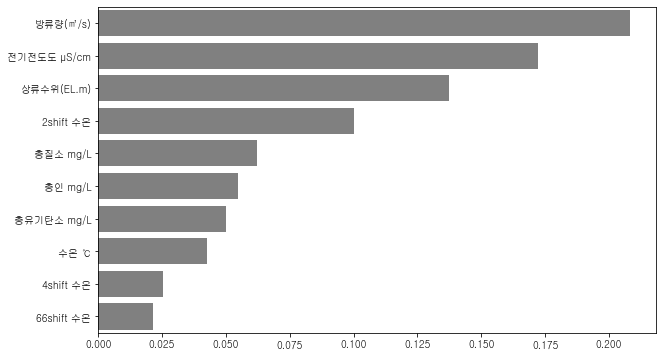

In [61]:
feature_series = pd.Series(data = estimator.feature_importances_, index = col_v)
feature_series = feature_series.sort_values(ascending = False)
sns.barplot(x = feature_series[:10], y = feature_series.index[:10], color = 'gray')
plt.show()

In [62]:
feature_series[:10]

방류량(㎥/s)       0.208069
전기전도도 μS/cm    0.172213
상류수위(EL.m)     0.137513
2shift 수온      0.100253
총질소 mg/L       0.061983
총인 mg/L        0.054593
총유기탄소 mg/L     0.050065
수온 ℃           0.042649
4shift 수온      0.025395
66shift 수온     0.021367
dtype: float64

In [63]:
print('score :', estimator.score(X_test, np.log1p(y_test)))

score : 0.9631339104219416


피처 정규화

In [64]:
scaler = StandardScaler()
scaler.fit(scb_df.loc[:, col_v])
scb_scaled = scaler.transform(scb_df.loc[:, col_v])

scb_df_scaled = pd.DataFrame(data = scb_scaled, columns = col_v)

In [65]:
scb_df_scaled.head()

,수온 ℃,전기전도도 μS/cm,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,상류수위(EL.m),방류량(㎥/s),2shift 수온,4shift 수온,6shift 수온,...,22shift 수온,24shift 수온,30shift 수온,36shift 수온,42shift 수온,48shift 수온,54shift 수온,60shift 수온,66shift 수온,72shift 수온
0,-0.583879,-0.517932,-0.938145,0.222144,-0.225036,0.778067,-0.198824,-0.509093,-0.459184,-0.434192,...,-0.708055,-0.683085,-0.608145,-0.421054,-0.692148,-0.757565,-0.732488,-0.557855,-0.819854,-0.882173
1,-0.596330,-0.517932,-1.035787,0.222144,-0.225036,0.778067,-0.199062,-0.533995,-0.484085,-0.434192,...,-0.708055,-0.695533,-0.620598,-0.433510,-0.639214,-0.757565,-0.732488,-0.607706,-0.757555,-0.894629
2,-0.621232,-0.517932,-1.035787,0.222144,-0.225036,0.778067,-0.198824,-0.583799,-0.508985,-0.459093,...,-0.708055,-0.707981,-0.633051,-0.495790,-0.586279,-0.770021,-0.732488,-0.657556,-0.695256,-0.907086
3,-0.658586,-0.540930,-1.035787,0.222144,-0.225036,0.774235,-0.204930,-0.596249,-0.533886,-0.483993,...,-0.670714,-0.707981,-0.645504,-0.570525,-0.533344,-0.770021,-0.744949,-0.694944,-0.632956,-0.907086
4,-0.671038,-0.563928,-1.035787,0.222144,-0.225036,0.766571,-0.218570,-0.621151,-0.583688,-0.508893,...,-0.620926,-0.707981,-0.657957,-0.607893,-0.458613,-0.770021,-0.757409,-0.682481,-0.570657,-0.894629


In [66]:
X_trains, X_tests, y_trains, y_tests = train_test_split(scb_df_scaled.loc[:, col_v], scb_df['클로로필-a mg/㎥'], random_state=42)
gb_regs = GradientBoostingRegressor(random_state=42)

parameters = {'max_depth':[5, 10, 15], 'learning_rate':[0.05, 0.1, 0.2]}

In [67]:
gb_grids = GridSearchCV(gb_regs, param_grid=parameters, cv=3)

In [68]:
gb_grids.fit(X_trains, np.log1p(y_trains))

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [5, 10, 15]})

In [69]:
scores_dfs = pd.DataFrame(gb_grids.cv_results_)

In [70]:
scores_dfs.sort_values(by=['rank_test_score'], inplace=True)
scores_dfs[['params', 'mean_test_score', 'rank_test_score']].head()

,params,mean_test_score,rank_test_score
5,"{'learning_rate': 0.1, 'max_depth': 15}",0.944113,1
2,"{'learning_rate': 0.05, 'max_depth': 15}",0.943174,2
7,"{'learning_rate': 0.2, 'max_depth': 10}",0.943159,3
8,"{'learning_rate': 0.2, 'max_depth': 15}",0.941856,4
4,"{'learning_rate': 0.1, 'max_depth': 10}",0.937699,5


In [71]:
gb_grids.best_params_

{'learning_rate': 0.1, 'max_depth': 15}

In [72]:
estimators = gb_grids.best_estimator_

In [73]:
preds = estimators.predict(X_tests)

In [74]:
for score, name in zip(estimators.feature_importances_, col_v):
    print(round(score, 2), name)

0.04 수온 ℃
0.17 전기전도도 μS/cm
0.05 총유기탄소 mg/L
0.06 총질소 mg/L
0.05 총인 mg/L
0.14 상류수위(EL.m)
0.21 방류량(㎥/s)
0.1 2shift 수온
0.03 4shift 수온
0.0 6shift 수온
0.0 8shift 수온
0.0 10shift 수온
0.0 12shift 수온
0.0 14shift 수온
0.0 16shift 수온
0.0 18shift 수온
0.0 20shift 수온
0.0 22shift 수온
0.01 24shift 수온
0.01 30shift 수온
0.01 36shift 수온
0.01 42shift 수온
0.01 48shift 수온
0.01 54shift 수온
0.02 60shift 수온
0.02 66shift 수온
0.02 72shift 수온


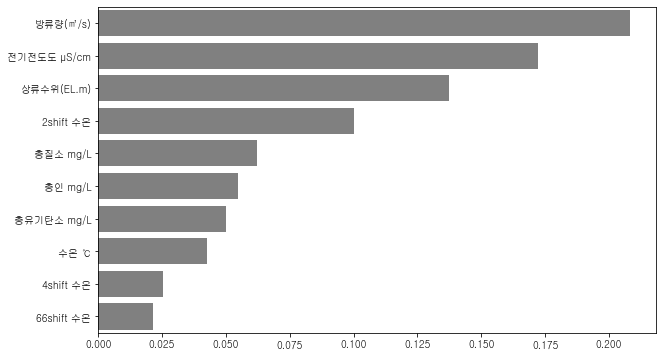

In [75]:
feature_seriess = pd.Series(data = estimators.feature_importances_, index = col_v)
feature_seriess = feature_seriess.sort_values(ascending = False)
sns.barplot(x = feature_seriess[:10], y = feature_seriess.index[:10], color = 'gray')
plt.show()

In [76]:
feature_seriess[:10]

방류량(㎥/s)       0.208069
전기전도도 μS/cm    0.172213
상류수위(EL.m)     0.137513
2shift 수온      0.100253
총질소 mg/L       0.061983
총인 mg/L        0.054593
총유기탄소 mg/L     0.050065
수온 ℃           0.042649
4shift 수온      0.025395
66shift 수온     0.021367
dtype: float64

In [77]:
print('score :', estimators.score(X_tests, np.log1p(y_tests)))

score : 0.9632346295047303
